In [1]:
import arcgis
from arcgis import *
from arcgis.mapping import MapImageLayer

In [2]:
#set environment
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

In [3]:
from arcgis.gis import GIS

from arcgis.raster.functions import *

## connect as an anonymous user
gis = GIS()

landsat_item = gis.content.search('"Landsat 8-9 Views"', 'Imagery Layer')[0]

landsat_item

<Item title:"Landsat 8-9 Views" type:Imagery Layer owner:esri>

In [4]:
landsat = landsat_item.layers[0]

In [5]:
def extract_stretch(bandids):
    return stretch(extract_band(landsat, bandids),
                   stretch_type='PercentClip',
                   min_percent=2, 
                   max_percent=2,
                   dra=True, 
                   gamma=[0.8,0.8,0.8])

In [6]:
aoi = {'xmax': -120.64, 'xmin': -121.64, 'ymax': 47.94, 'ymin': 47.55, 'spatialReference': 4326} #define area of interest

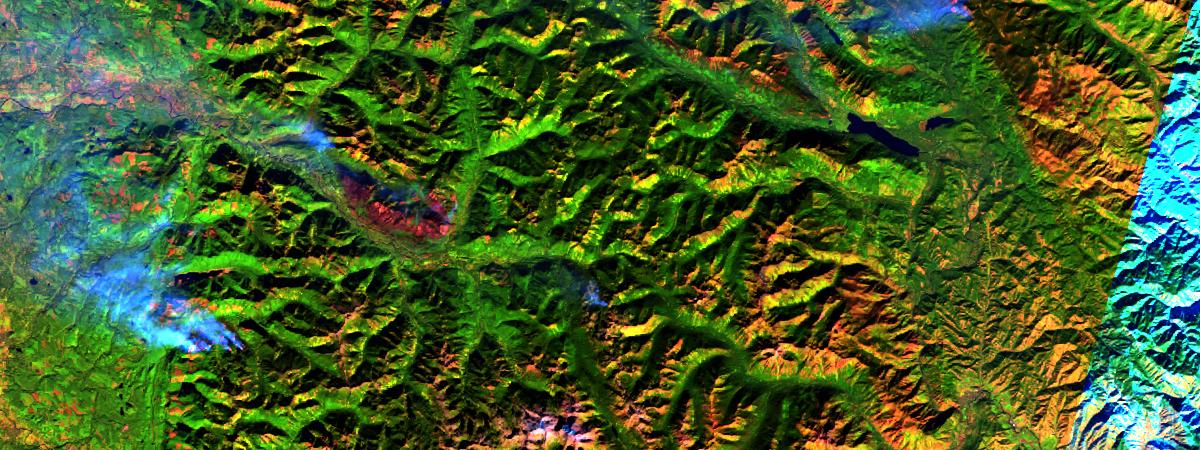

In [7]:
boltcreek = extract_stretch([6,5,2]) #vegetation band combo, green = lush vegetation
boltcreek.extent = {'xmax': -120.64, 'xmin': -121.64, 'ymax': 47.94, 'ymin': 47.55, 'spatialReference': 4326}
boltcreek

In [8]:
import pandas as pd
from datetime import datetime

selected = landsat.filter_by(where="(Category = 1)", #Landsat 8 and 9 imagery in this layer is comprised of Collection 2 Level-1 data
                             time=[datetime(2022, 8, 1), datetime(2022, 9, 10)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(5)

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
10,3794041,2022-08-29 18:56:11,LC08_L1TP_046027_20220829_20220910_02_T1_MTL,0.0022,27,"{""rings"": [[[-13396134.7678, 6117219.887599997..."
11,3781378,2022-08-30 18:49:43,LC09_L1TP_045027_20220830_20220831_02_T1_MTL,0.0938,27,"{""rings"": [[[-13223031.6639, 6117082.2914], [-..."
12,3788146,2022-09-06 18:55:29,LC09_L1TP_046026_20220906_20220906_02_T1_MTL,0.011,26,"{""rings"": [[[-13325495.2975, 6355473.455499999..."
13,3788147,2022-09-06 18:55:53,LC09_L1TP_046027_20220906_20220906_02_T1_MTL,0.0019,27,"{""rings"": [[[-13393656.8468, 6117099.931599997..."
14,3802554,2022-09-07 18:50:03,LC08_L1TP_045027_20220907_20220914_02_T1_MTL,0.2272,27,"{""rings"": [[[-13224593.9496, 6117209.736699998..."


In [9]:
prefire = landsat.filter_by('OBJECTID=3802554') # 2022-9-07

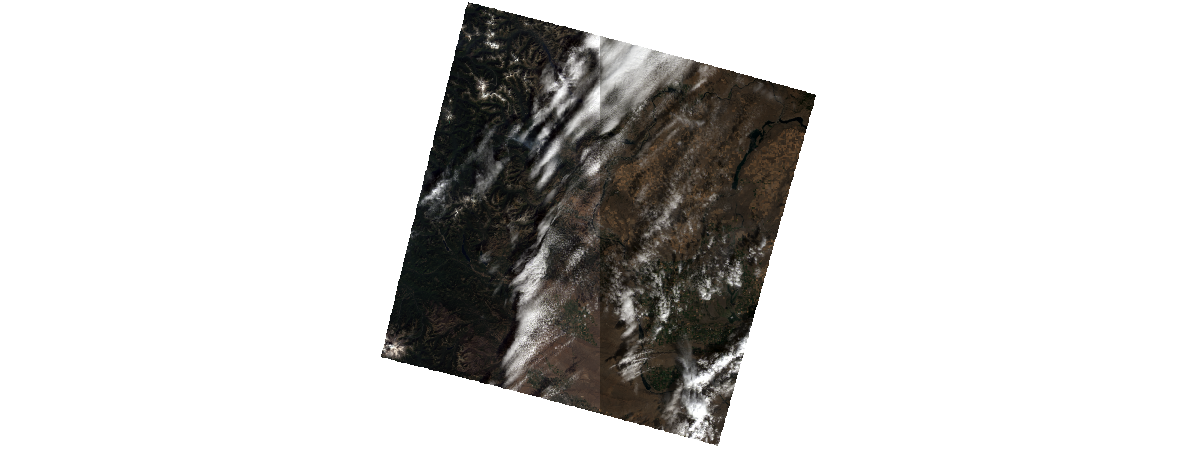

In [10]:
from arcgis.raster.functions import *

apply(prefire, 'Natural Color with DRA')

In [11]:
selected = landsat.filter_by(where="(Category = 1)",
                             time=[datetime(2022, 10, 1), datetime(2022, 10, 10)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df.tail(5)

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,3833943,2022-10-01 18:49:50,LC09_L1TP_045027_20221001_20221001_02_T1_MTL,0.0113,27,"{""rings"": [[[-13222596.824900001, 6116884.5379..."
1,3844955,2022-10-08 18:55:38,LC09_L1TP_046026_20221008_20221008_02_T1_MTL,0.0171,26,"{""rings"": [[[-13326231.555300001, 6355538.6565..."
2,3844956,2022-10-08 18:56:02,LC09_L1TP_046027_20221008_20221008_02_T1_MTL,0.0111,27,"{""rings"": [[[-13394551.8037, 6117131.045699999..."
3,3852429,2022-10-09 18:50:02,LC08_L1TP_045027_20221009_20221013_02_T1_MTL,0.0066,27,"{""rings"": [[[-13222796.6612, 6117284.147600003..."


In [12]:
midfire = landsat.filter_by('OBJECTID=3852429') # 2022-10-09 

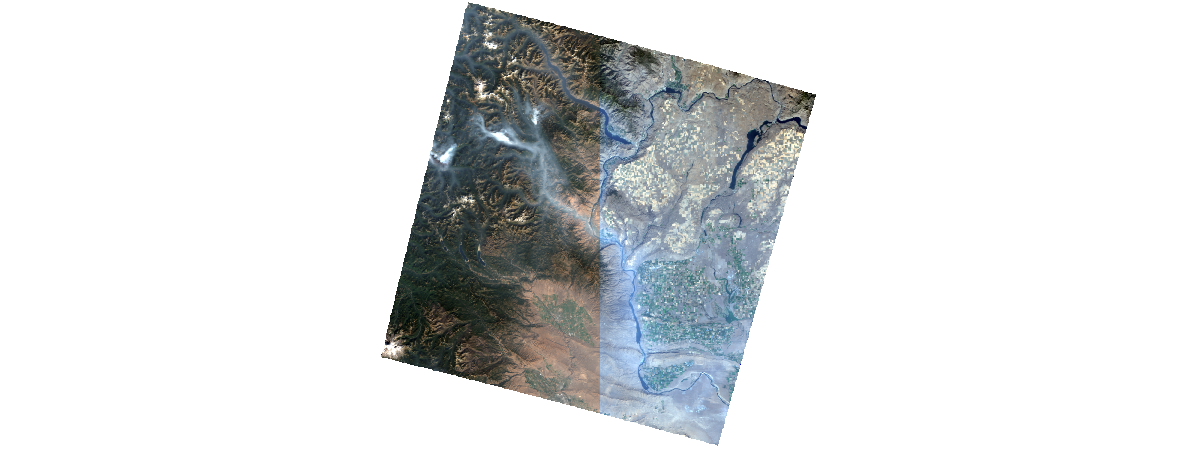

In [13]:
apply(midfire, 'Natural Color with DRA')

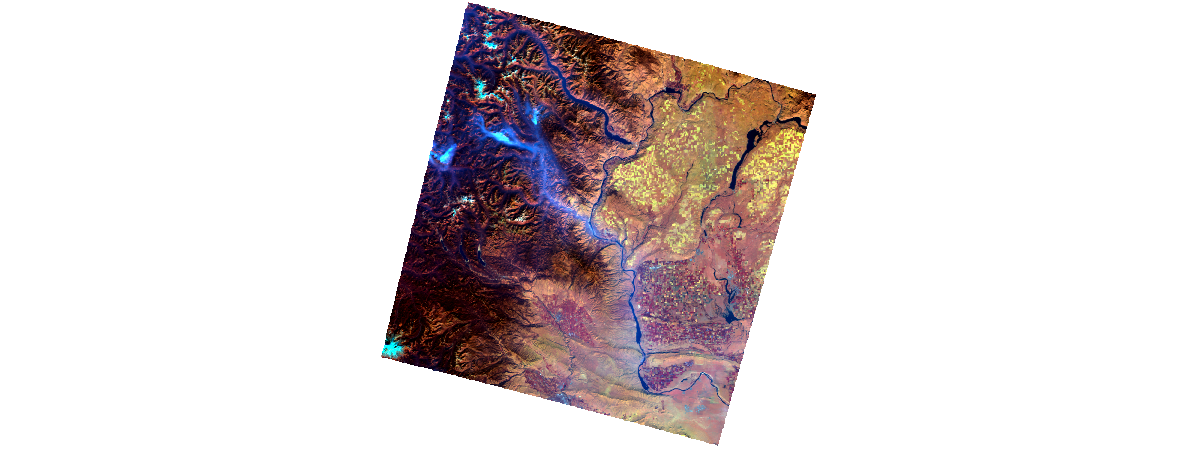

In [14]:
extract_band(midfire, [6,4,1])

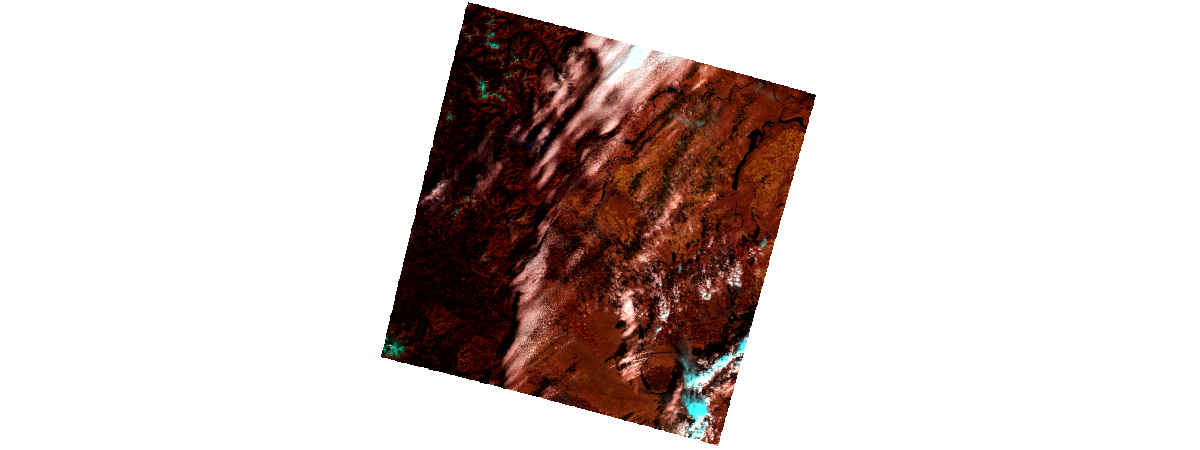

In [15]:
extract_band(prefire, [6,4,1])

In [16]:
#The Burn Area Index (BAI) uses the reflectance values in the red and NIR portion of the spectrum to identify the areas of the terrain affected by fire.
nbr_prefire  = band_arithmetic(prefire, "(b5 - b7) / (b5 + b7+1000)")
nbr_postfire = band_arithmetic(midfire, "(b5 - b7) / (b5 + b7+1000)")

nbr_diff = nbr_prefire - nbr_postfire

In [17]:
burnt_areas = colormap(remap(nbr_diff, #sourced from Esri
                             input_ranges=[0.1,  0.27,  # low severity 
                                           0.27, 0.44,  # medium severity
                                           0.44, 0.66,  # moderate severity
                                           0.66, 1.00], # high severity burn
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, 0.1], astype='u8'), 
                             colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0,    0]])

In [18]:
ext = {'xmax': -120.64, 'xmin': -121.64, 'ymax': 47.94, 'ymin': 47.55,
       "spatialReference": {"wkid": 102100, "latestWkid": 3857}, "type": "extent"}
pixx = (ext['xmax'] - ext['xmin']) / 1200.0
pixy = (ext['ymax'] - ext['ymin']) / 450.0

res = burnt_areas.compute_histograms(ext, pixel_size={'x':pixx, 'y':pixy})

numpix = 0
histogram = res['histograms'][0]['counts'][1:]
for i in histogram:
    numpix += i

In [19]:
from IPython.display import HTML
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres

HTML('<h3>Bolt Creek fire has consumed <i>{:,} acres</i>  till {}</h3>.'.format(int(acres), df.iloc[-1]['AcquisitionDate'].date()))

C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:3050: RuntimeWarning: invalid value encountered in true_divide
  x = x / sx


ValueError: 'label' must be of length 'x'

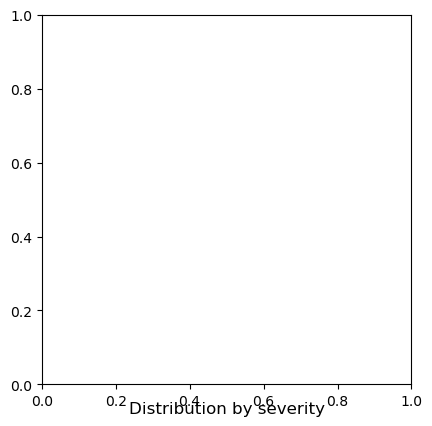

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Distribution by severity', y=-0.1)
plt.pie(histogram, labels=['Low Severity', 'Medium Severity', 'Moderate Severity', 'High Severity']);
plt.axis('equal');